### 2. Load Base Model

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "NousResearch/Yarn-Mistral-7b-64k"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
    # torch_dtype=torch.float32
)

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                            #  use_flash_attention_2=True,
                                            #  quantization_config=bnb_config,
                                             trust_remote_code=True)

# model = AutoModelForCausalLM.from_pretrained(base_model_id,
#   use_flash_attention_2=True,
#   torch_dtype=torch.bfloat16,
#   device_map="auto",
#   trust_remote_code=True)

: 

### 3. Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [ ]:
# import matplotlib.pyplot as plt

# def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
#     lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
#     lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
#     print(len(lengths))

#     # Plotting the histogram
#     plt.figure(figsize=(10, 6))
#     plt.hist(lengths, bins=20, alpha=0.7, color='blue')
#     plt.xlabel('Length of input_ids')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Lengths of input_ids')
#     plt.show()

# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same.(self-supervised fine-tuning)

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

2 pad on the left and end, prompt start with 1

In [ ]:
# print(tokenized_train_dataset[1]['input_ids'])

Now all the samples should be the same length, `max_length`.

In [ ]:
# plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### Try Base Model

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [17]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    # padding_side="left",
    # add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from IPython.display import display, Markdown

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = model.generate(**inputs, max_new_tokens=100)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

make_inference("How does the observed reversible depression of cellular immunity following surgical operations, as evidenced by significant reductions in circulating numbers of various lymphocyte subpopulations, correlate with the degree of surgical trauma in patients with benign diseases?", "Surgical operations have been shown to cause a variety of immunological disturbances in man both in vivo and in vitro. With few exceptions the overall picture is one of a generalized state of immunodepression in the postoperative period. The implications of these observations are that host defences may be compromised by surgical procedures, thus providing a 'fertile soil' for bacterial invasion and tumour cell metastasis at the very time when risks from invading pathogens and viable tumour cells are maximal. We have studied the effects of surgical operations on the immune system in 35 patients with benign disease. Surgical procedures were classified as either minor (n = 15) or major (n = 20). A panel of monoclonal antibodies was used to identify peripheral blood lymphocyte subpopulations and analysis was performed using flow cytometry. Simultaneous estimations of plasma alpha-1 proteinase inhibitor (alpha-1-PI), alpha-2-macroglobulin (alpha-2-M), alpha-2-pregnancy-associated glycoprotein (alpha-2-PAG) and plasma suppressive activity (PSA) on stimulated allogeneic lymphocytes were performed before operation and on postoperative days 1, 3, 7, 17 and 21. Circulating numbers of all lymphocyte subpopulations fell significantly following surgery, except for B lymphocytes which did not change. The magnitude, and duration of the reduction in cell numbers and the subpopulation affected was significantly related to the degree of surgical trauma, and returned to pre-operative values by postoperative day 7. Changes in alpha-1-PI, alpha-2-M, alpha-2-PAG and PSA were also significantly related to the degree of surgical trauma, and these plasma changes persisted longer than the cellular disturbances. Surgical operations induce a reversible depression of cellular immunity which precedes plasma suppressive activity in its return to pre-operative levels. Immunostimulating agents such as interferon and the interleukins deserve evaluation as prophylactic agents pre-operatively.")

In [ ]:
# # Re-init the tokenizer so it doesn't add padding or eos token
# model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# model.eval()
# with torch.no_grad():
#     print(tokenizer.decode(model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

### LoRA

Apply some preprocessing to the model to prepare it for training. For that use the (`prepare_model_for_kbit_training` method from PEFT.)

In [ ]:
# from peft import prepare_model_for_kbit_training

# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model)

In [ ]:
# TypeError: MistralPreTrainedModel._set_gradient_checkpointing() missing 1 required positional argument: 'module'

In [ ]:
# def print_trainable_parameters(model):
#     """
#     Prints the number of trainable parameters in the model.
#     """
#     trainable_params = 0
#     all_param = 0
#     for _, param in model.named_parameters():
#         all_param += param.numel()
#         if param.requires_grad:
#             trainable_params += param.numel()
#     print(
#         f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
#     )

In [ ]:
# print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
# print_trainable_parameters(model)

In [ ]:
# print(model)

### Accelerator

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
# !pip install -q wandb -U

import wandb, os
wandb.login()
wandb.init()

wandb_project = "64k-finetune-Alpaca+1k.ipynb"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fdfdfd (benjamin_cartel). Use `wandb login --relogin` to force relogin


In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

### 5. Train

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "Fine-Tune-YM64k"
base_model_name = "YM64k"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset, 
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        # gradient_checkpointing=True,
        max_steps=1000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=50,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 20                                                              0 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

2023-11-18 14:57:47.038103: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 14:57:47.059652: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 14:57:47.059682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 14:57:47.059693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 14:57:47.065181: I tensorflow/core/platform/cpu_feature_g

Step,Training Loss,Validation Loss
50,0.992800,0.894147
100,0.877000,0.864627
150,0.864200,0.859976
200,0.857600,0.856962
250,0.834900,0.853505
300,0.850000,0.851538
350,0.854800,0.849771
400,0.836600,0.847528
450,0.840800,0.846427
500,0.864500,0.845815


TrainOutput(global_step=1000, training_loss=0.8535341682434082, metrics={'train_runtime': 135218.2002, 'train_samples_per_second': 0.059, 'train_steps_per_second': 0.007, 'total_flos': 1.76841553870848e+17, 'train_loss': 0.8535341682434082, 'epoch': 0.17})

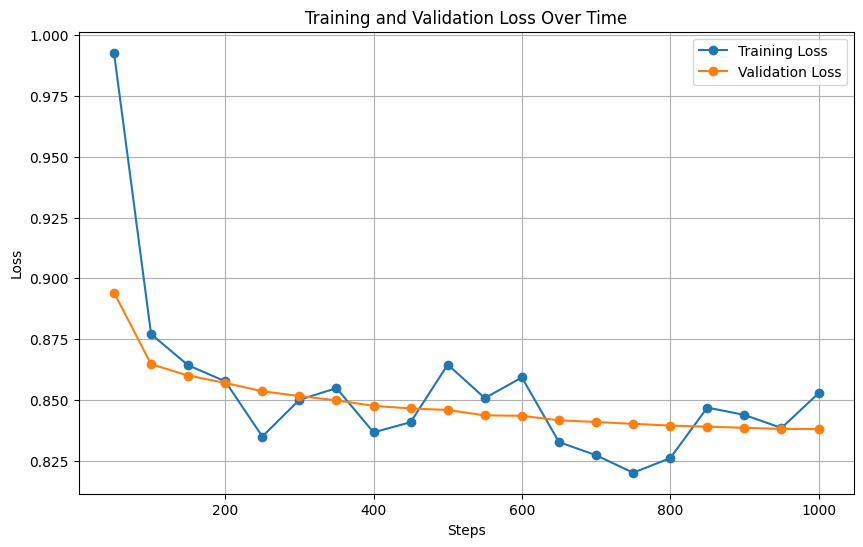

In [ ]:
import matplotlib.pyplot as plt

# # Your data
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
training_loss = [0.992800, 0.877000, 0.864200, 0.857600, 0.834900, 0.850000, 0.854800, 0.836600, 0.840800, 0.864500, 0.850700, 0.859200, 0.832600, 0.827200, 0.820000, 0.826000, 0.846800, 0.843800, 0.838400, 0.852700]
validation_loss = [0.894147, 0.864627, 0.859976, 0.856962, 0.853505, 0.851538, 0.849771, 0.847528, 0.846427, 0.845815, 0.843595, 0.843434, 0.841565, 0.840871, 0.840112, 0.839395, 0.838952, 0.838474, 0.838047, 0.837937]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Want to save the trained model.

In [ ]:
output_dir = "./trained3_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Want to push to hub.

In [ ]:
model.push_to_hub("finetune-Yarn64k-qlora-Alpaca-1kMeds")

adapter_model.safetensors:   0%|          | 0.00/340M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FlexingD/finetune-Yarn64k-qlora-Alpaca-1kMeds/commit/afdc620634a75f74ac0135f3a4dd6bc1ef98d190', commit_message='Upload model', commit_description='', oid='afdc620634a75f74ac0135f3a4dd6bc1ef98d190', pr_url=None, pr_revision=None, pr_num=None)

### 6. Try the Trained Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "NousResearch/Yarn-Mistral-7b-128k"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "NousResearch/Yarn-Mistral-7b-64k"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(base_model_id, use_flash_attention_2=True, quantization_config=bnb_config, trust_remote_code=True)

# model = AutoModelForCausalLM.from_pretrained(base_model_id,
#   use_flash_attention_2=True,
#   torch_dtype=torch.bfloat16,
#   device_map="auto",
#   trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(model, "YM64k-Fine-Tune-YM64k/checkpoint-1000")

In [ ]:
merged_model = ft_model.merge_and_unload()
merged_model.save_pretrained(merged_model)

/home/cs01/miniconda3/envs/qlora/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:213: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


NotImplementedError: You are calling `save_pretrained` on a 4-bit converted model. This is currently not supported

### 7. Inference

In [ ]:
from IPython.display import display, Markdown

def make_inference_(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  outputs = ft_model.generate(**inputs, max_new_tokens=1000)
  display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))

make_inference("How does the establishment of the COVAX Facility contribute to addressing the global challenges posed by infectious diseases, and what key lessons can be drawn from this collaborative effort for future pandemic preparedness and response strategies?", "One key lesson that we’ve learned from this pandemic is that nobody is safe until everyone is safe because infectious diseases do not respect borders. Therefore, global equitable access to vaccines, particularly protecting health care workers and those most-at-risk – wherever they are, and whatever their income level – is the only way to lessen the public health and economic impact of the pandemic on individuals, communities, and nations.This is why the COVAX Facility was set up. COVAX is a global collaboration co-led by Gavi, the Centre for Epidemic Preparedness Innovations (CEPI) and WHO – working in partnership with participating countries governments, vaccine manufacturers, UNICEF, the World Bank, and others. This unprecedented international collaboration in terms of technological innovation, funding for vaccines and new models of public-private cooperation to enable rapid roll-out of vaccines once doses are delivered is going to be a valuable learning for future pandemics.")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Below is an instruction that describes a task, paired with an input that provides further context.

### Instruction: 
How does the establishment of the COVAX Facility contribute to addressing the global challenges posed by infectious diseases, and what key lessons can be drawn from this collaborative effort for future pandemic preparedness and response strategies?

### Input: 
One key lesson that we’ve learned from this pandemic is that nobody is safe until everyone is safe because infectious diseases do not respect borders. Therefore, global equitable access to vaccines, particularly protecting health care workers and those most-at-risk – wherever they are, and whatever their income level – is the only way to lessen the public health and economic impact of the pandemic on individuals, communities, and nations.This is why the COVAX Facility was set up. COVAX is a global collaboration co-led by Gavi, the Centre for Epidemic Preparedness Innovations (CEPI) and WHO – working in partnership with participating countries governments, vaccine manufacturers, UNICEF, the World Bank, and others. This unprecedented international collaboration in terms of technological innovation, funding for vaccines and new models of public-private cooperation to enable rapid roll-out of vaccines once doses are delivered is going to be a valuable learning for future pandemics.

### Response: 
The COVAX Facility is a global collaboration co-led by Gavi, the Centre for Epidemic Preparedness Innovations (CEPI) and WHO – working in partnership with participating countries governments, vaccine manufacturers, UNICEF, the World Bank, and others. This unprecedented international collaboration in terms of technological innovation, funding for vaccines and new models of public-private cooperation to enable rapid roll-out of vaccines once doses are delivered is going to be a valuable learning for future pandemics.

### Explanation: 
The COVAX Facility is a global collaboration co-led by Gavi, the Centre for Epidemic Preparedness Innovations (CEPI) and WHO – working in partnership with participating countries governments, vaccine manufacturers, UNICEF, the World Bank, and others. This unprecedented international collaboration in terms of technological innovation, funding for vaccines and new models of public-private cooperation to enable rapid roll-out of vaccines once doses are delivered is going to be a valuable learning for future pandemics.

### Score: 
0.0

### Source: 
https://www.who.int/news/item/25-01-2021-covax-facility-launches-global-access-to-covid-19-vaccines

### Estimated Sentiment: 
 

### Keyword(s): 
 

### Entities in input: 
 

### Proportion of Sundial Words: 
 

### Classifier: 
 

### Length: 
 

#### Classifier explain

 

#### Classifier confidences

 

In [ ]:
# model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

# ft_model.eval()
# with torch.no_grad():
#     print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


|The conclusion was that the group of people who habitually ate 800g or more of fruit and vegetables a day – which atv10 portions, is considerably higher compared to the 5 currently recommended – lowered their risk of adverse health conditions. Cancer risk was reduced around the 600g mark, in fact. This study also tried to identify the benefits of different fruit and vegetables in various health conditions. However, this study is unlikely to translate into a current recommendation for the simple fact that most people today do not eat even the 5 portions that have been promoted by public health agencies.| According to this context, answer this question: How does the recent study highlighting the health benefits of consuming 800g or more of fruits and vegetables daily, especially in reducing the risk of adverse health conditions, impact current dietary recommendations?
 ### Answer: The study suggests that increasing the intake of fruits and vegetables beyond the current recommended amoun